In [48]:
# imports
%matplotlib inline
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

### Functions

In [3]:
def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def read_bin_files_to_array(folder_path):
    bin_files = []
    filenames = sorted(os.listdir(folder_path))
    for filename in filenames:
        if filename.endswith('.bin'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                data = np.fromfile(file, dtype=np.float32)
                bin_files.append(data)

    return bin_files


def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def split_train_val_test(images, masks):

    train_images = []
    train_masks = []
    val_images = []
    val_masks = []
    test_images = []
    test_masks = []

    for i in range(len(images)): 

    # these numbers are made specifically for this dataset 
        
        if i < 27: 
            train_images.append(images[i])
            train_masks.append(masks[i])
        elif i < 32:
            val_images.append(images[i])
            val_masks.append(masks[i])
        else: 
            test_images.append(images[i])
            test_masks.append(masks[i])

    return train_images, train_masks, val_images, val_masks, test_images, test_masks

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_masks(image_array):
    cropped_images = []

    for i in range(len(image_array)): 
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (288, 307), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def add_padding(image_array, amt_x, amt_y): 
    
    padded_images = []
    
    for image in image_array: 

        padded_image = cv2.copyMakeBorder(
            image,
            amt_y,
            amt_y,
            amt_x,
            amt_x,
            cv2.BORDER_CONSTANT,
            value=(255,255,255)
        )
        
        padded_images.append(padded_image)
        
    return padded_images

def zoom_at(image_array, zoom, coord=None):
    
    zoomed_array = []
    
    for img in image_array: 
        
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array


def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images

### Apply Functions

In [59]:
images = read_images_to_array('../data/invotive_data/')
depth = read_images_to_array('./data/')

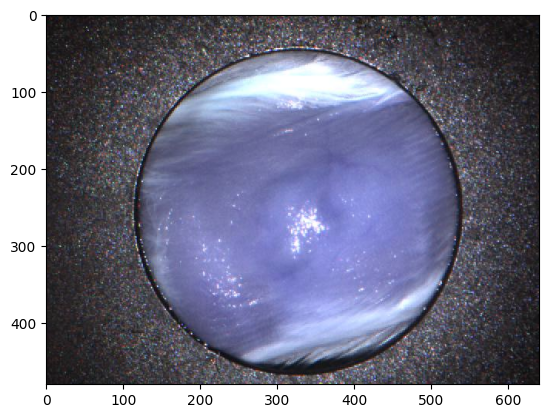

In [66]:
# sanity check 

rand = random.randint(0, len(images) -1)

plt.imshow(images[1])

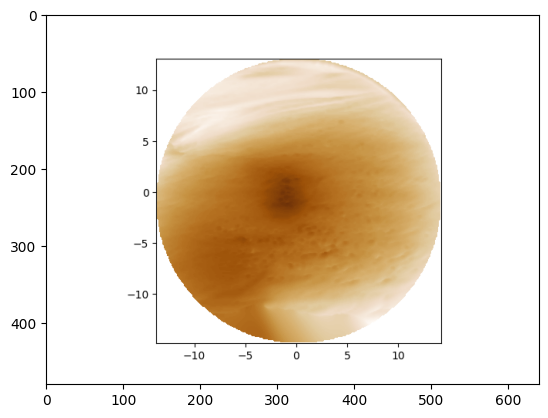

In [67]:
plt.imshow(depth[1])